# Algo Trading News or Noise

## Imports
---

In [121]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from dotenv import load_dotenv
import panel as pn
from panel.interact import interact
from panel import widgets
import alpaca_trade_api as tradeapi
import quandl
import os
import requests
import ccxt
import time
import tensorflow

## Read in data
---

In [122]:
ETF_csv = Path("Resources/ETFs0.csv")
ETF_df = pd.read_csv(ETF_csv, index_col='Unnamed: 0', infer_datetime_format=True, parse_dates=True)
ETF_df = ETF_df.drop(ETF_df.index[0])
ETF_df.index = pd.to_datetime(ETF_df.index, utc=True).date
ETF_df.sort_index(inplace=True)
ETF_df.tail()

,SPY,XLF,XLK,XLU,XLI,XLV,XLY,XLP,XLB,XOP,XHB,XME,XRT,ETH,LTC
2020-12-24,368.9899,28.94,129.05,61.19,88.01,111.48,157.91,66.44,71.58,58.99,59.40,32.57,64.740,20.09,39.30
2020-12-28,372.1400,29.07,130.52,61.48,88.09,111.72,159.68,66.97,71.28,57.92,58.41,32.40,65.070,20.25,39.41
2020-12-29,371.4800,28.97,129.89,61.47,87.52,112.24,159.74,67.42,71.12,57.35,57.92,32.26,64.275,20.02,39.03
2020-12-30,371.9300,29.11,129.83,61.79,88.13,112.24,160.69,67.13,72.10,59.32,58.16,33.40,64.910,20.26,38.68
2020-12-31,373.8500,29.47,130.07,62.70,88.59,113.43,160.77,67.05,72.38,58.49,57.63,33.43,64.330,20.21,38.91


## Set analysis inputs
---


In [123]:
ticker = input("Please enter the symbol name in caps:\n")

# Set intial capital
initial_capital = input("Please input the amount of capital you have (USD):\n")
initial_capital = int(initial_capital)

# Set lot size
share_size = input("Please input the lot size you wish to trade:\n")
share_size = int(share_size)

# Set windows
short_window = input("Please choose a short moving average lookback window: 20, 50 days\n")
short_window = int(short_window)
long_window = input("Please choose a long moving average lookback window: 100, 200 days\n")
long_window = int(long_window)
bollinger_window = input("Please choose a 10, 20, 50 bollinger lookback window\n")
bollinger_window = int(bollinger_window)

Please enter the symbol name in caps:
 SPY
Please input the amount of capital you have (USD):
 10000
Please input the lot size you wish to trade:
 1
Please choose a short moving average lookback window: 20, 50 days
 50
Please choose a long moving average lookback window: 100, 200 days
 200
Please choose a 10, 20, 50 bollinger lookback window
 20



## Signal generation
---
### SMA
*Simple Moving Average for a given lookback window*

In [181]:
# Grab `ticker` from the dataset
SMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [182]:
# Generate the short and long moving averages (50 and 100 days, respectively)
SMA_df["SMA_short"] = SMA_df[{ticker}].rolling(window=short_window).mean()
SMA_df["SMA_long"] = SMA_df[{ticker}].rolling(window=long_window).mean()

In [183]:
# Initialize the new `Signal` column
SMA_df["signal"] = 0.0

# Generate the trading signal -1, 1,
# where -1 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
SMA_df["signal"][short_window:] = np.where(
    SMA_df["SMA_short"][short_window:] < SMA_df["SMA_long"][short_window:], -1.0, 1.0
)

In [184]:
# Calculate the points in time at which a position should be taken, 1 or -1
SMA_df["entry/exit"] = SMA_df["signal"].diff()

In [185]:
# Tidy up
SMA_df.dropna(inplace=True)
SMA_df.tail()

,SPY,SMA_short,SMA_long,signal,entry/exit
2020-12-24,368.9899,355.74239,320.438481,1.0,0.0
2020-12-28,372.1400,356.23499,320.944531,1.0,0.0
2020-12-29,371.4800,356.71959,321.604881,1.0,0.0
2020-12-30,371.9300,357.31779,322.193581,1.0,0.0
2020-12-31,373.8500,357.92799,322.857781,1.0,0.0


---
### EMA
*Exponential-weighted Moving Average for a given lookback window*

In [186]:
# Grab `ticker` from the dataset
EMA_df = ETF_df[f'{ticker}'].copy().to_frame()

In [187]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
EMA_df['EMA_short'] = EMA_df[{ticker}].ewm(halflife=short_window).mean()
EMA_df['EMA_long'] = EMA_df[{ticker}].ewm(halflife=long_window).mean()

In [188]:
# Initialize signal column
EMA_df["signal"] = 0.0

# Construct a crossover trading signal
# where -1 is when the EMA50 is under the EMA200, and
# where 1 is when the EMA50 is higher (or crosses over) the EMA200
EMA_df["signal"][short_window:] = np.where(
    EMA_df["EMA_short"][short_window:] < EMA_df["EMA_long"][short_window:], -1.0, 1.0
)

In [189]:
# Calculate the points in time at which a position should be taken, 1 or -1
EMA_df["entry/exit"] = EMA_df["signal"].diff()

In [190]:
# Tidy up
EMA_df.dropna(inplace=True)
EMA_df.tail()

,SPY,EMA_short,EMA_long,signal,entry/exit
2020-12-24,368.9899,339.752754,305.589812,1.0,0.0
2020-12-28,372.1400,340.198639,305.820074,1.0,0.0
2020-12-29,371.4800,340.629299,306.047256,1.0,0.0
2020-12-30,371.9300,341.060225,306.275208,1.0,0.0
2020-12-31,373.8500,341.511651,306.509015,1.0,0.0


---
### BBD
*Bollinger Bands for a given lookback window*

In [191]:
# Grab `ticker` from the dataset
BBD_df = ETF_df[f'{ticker}'].copy().to_frame()

In [192]:
# Calculate rolling mean and standard deviation
BBD_df['BBD_mid'] = BBD_df[{ticker}].rolling(window=bollinger_window).mean()
BBD_df['BBD_std'] = BBD_df[{ticker}].rolling(window=bollinger_window).std()

In [193]:
# Calculate upper and lowers bands of bollinger band
BBD_df['BBD_upper']  = BBD_df['BBD_mid'] + (BBD_df['BBD_std'] * 1)
BBD_df['BBD_lower']  = BBD_df['BBD_mid'] - (BBD_df['BBD_std'] * 1)

In [194]:
# Construct a crossover trading signal
# where 1 is when the close is under the lower bound, and
# where -1 is when the close is higher the upper bound
BBD_df['long'] = np.where(BBD_df[f'{ticker}'] < BBD_df['BBD_lower'], 1.0, 0.0)
BBD_df['short'] = np.where(BBD_df[f'{ticker}'] > BBD_df['BBD_upper'], -1.0, 0.0)

In [195]:
# Calculate bollinger band trading signal
BBD_df['signal'] = BBD_df['long'] + BBD_df['short']
BBD_df["entry/exit"] = BBD_df["signal"].diff()

In [196]:
# Tidy up
BBD_df.dropna(inplace=True)
BBD_df.tail()

,SPY,BBD_mid,BBD_std,BBD_upper,BBD_lower,long,short,signal,entry/exit
2020-12-24,368.9899,367.568975,2.439630,370.008605,365.129345,0.0,0.0,0.0,0.0
2020-12-28,372.1400,367.993475,2.460381,370.453856,365.533094,0.0,-1.0,-1.0,-1.0
2020-12-29,371.4800,368.467475,2.136852,370.604327,366.330623,0.0,-1.0,-1.0,0.0
2020-12-30,371.9300,368.765475,2.185264,370.950739,366.580211,0.0,-1.0,-1.0,0.0
2020-12-31,373.8500,369.119980,2.406666,371.526646,366.713314,0.0,-1.0,-1.0,0.0


---
### RSI
*Relative Strength Index for a given lookback window*

In [197]:
# Calculate daily change
RSI_df = ETF_df[f'{ticker}'].copy().to_frame()
RSI_df['change'] = RSI_df[f'{ticker}'].diff(1)

# Caculate gain / loss from every changes and add as column to RSI_df
RSI_df['gain'] = np.select([RSI_df['change']>0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)
RSI_df['loss'] = np.select([RSI_df['change']<0, RSI_df['change'].isna()],
                       [RSI_df['change'], np.nan],
                       default=0)

# Create avg_gain / avg_loss columns with all nan
RSI_df['avg_gain'] = np.nan
RSI_df['avg_loss'] = np.nan

# Set the window (in this example we are using 14 days, should we make this an input as well?)
n = 14

# calculate rolling 14 day avg or gains and losses and add to the avg_gain and avg_loss columns
RSI_df['avg_gain'][n] = RSI_df['gain'].rolling(window=n).mean().dropna().iloc[0]
RSI_df['avg_loss'][n] = RSI_df['loss'].rolling(window=n).mean().dropna().iloc[0]
for i in range(n+1, RSI_df.shape[0]):
    RSI_df['avg_gain'].iloc[i] = (RSI_df['avg_gain'].iloc[i-1] * (n - 1) + RSI_df['gain'].iloc[i]) / n
    RSI_df['avg_loss'].iloc[i] = (RSI_df['avg_loss'].iloc[i-1] * (n - 1) + RSI_df['loss'].iloc[i]) / n

    # Calculate RS and RSI
RSI_df['rs'] = abs(RSI_df['avg_gain'] / RSI_df['avg_loss'])
RSI_df['rsi'] = 100 - (100 / (1 + RSI_df['rs'] ))
RSI_df.head(25)
# Initialize the new `Signal` column
RSI_df["signal"] = 0.0
RSI_df.head()

# Generate the trading signal -1, 1,
# where -1 is when the RSI is above 70
# where 1 is when the RSI is below 30
for i in range(0, len(RSI_df)):
    if RSI_df['rsi'].iloc[i] > 70:
        RSI_df['signal'].iloc[i] = -1
    elif RSI_df['rsi'].iloc[i] < 30:
        RSI_df['signal'].iloc[i] = 1
    else:
        RSI_df['signal'].iloc[i] = 0
RSI_df.head(50)

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df["entry/exit"] = RSI_df["signal"]
RSI_df.tail()

,SPY,change,gain,loss,avg_gain,avg_loss,rs,rsi,signal,entry/exit
2020-12-24,368.9899,1.4599,1.4599,0.00,1.159667,-0.791133,1.465831,59.445718,0.0,0.0
2020-12-28,372.1400,3.1501,3.1501,0.00,1.301841,-0.734623,1.772120,63.926525,0.0,0.0
2020-12-29,371.4800,-0.6600,0.0000,-0.66,1.208852,-0.729293,1.657567,62.371596,0.0,0.0
2020-12-30,371.9300,0.4500,0.4500,0.00,1.154649,-0.677201,1.705031,63.031849,0.0,0.0
2020-12-31,373.8500,1.9200,1.9200,0.00,1.209316,-0.628829,1.923123,65.790018,0.0,0.0


---
### MACD
*Moving Average Convergence/ Divergence for a given lookback window*

In [198]:
########################### TO DO ########################### 

## Backtesting
---
### Simulated portfolio
*Evaluate historic signal performance*

In [199]:
# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
SMA_df["position"] = share_size * SMA_df["signal"]
EMA_df["position"] = share_size * EMA_df["signal"]
BBD_df["position"] = share_size * BBD_df["signal"]
RSI_df["position"] = share_size * RSI_df["signal"]

In [200]:
# Find the points in time where a 500 share position is bought or sold
SMA_df["entry/exit position"] = SMA_df["position"].diff()
EMA_df["entry/exit position"] = EMA_df["position"].diff()
BBD_df["entry/exit position"] = BBD_df["position"].diff()
RSI_df["entry/exit position"] = RSI_df["position"].diff()

In [201]:
# Multiply share price by entry/exit positions and get the cumulatively sum
SMA_df["portfolio holdings"] = (SMA_df[f'{ticker}'] * SMA_df["entry/exit position"].cumsum())
EMA_df["portfolio holdings"] = (EMA_df[f'{ticker}'] * EMA_df["entry/exit position"].cumsum())
BBD_df["portfolio holdings"] = (BBD_df[f'{ticker}'] * BBD_df["entry/exit position"].cumsum())
RSI_df["portfolio holdings"] = (RSI_df[f'{ticker}'] * RSI_df["entry/exit position"].cumsum())

In [202]:
# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
SMA_df["portfolio cash"] = (initial_capital - (SMA_df[f'{ticker}'] * SMA_df["entry/exit position"]).cumsum())
EMA_df["portfolio cash"] = (initial_capital - (EMA_df[f'{ticker}'] * EMA_df["entry/exit position"]).cumsum())
BBD_df["portfolio cash"] = (initial_capital - (BBD_df[f'{ticker}'] * BBD_df["entry/exit position"]).cumsum())
RSI_df["portfolio cash"] = (initial_capital - (RSI_df[f'{ticker}'] * RSI_df["entry/exit position"]).cumsum())

In [203]:
# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
SMA_df["portfolio total"] = (SMA_df["portfolio cash"] + SMA_df["portfolio holdings"])
EMA_df["portfolio total"] = (EMA_df["portfolio cash"] + EMA_df["portfolio holdings"])
BBD_df["portfolio total"] = (BBD_df["portfolio cash"] + BBD_df["portfolio holdings"])
RSI_df["portfolio total"] = (RSI_df["portfolio cash"] + RSI_df["portfolio holdings"])

In [204]:
# Calculate the portfolio daily returns
SMA_df["portfolio daily returns"] = SMA_df["portfolio total"].pct_change()
EMA_df["portfolio daily returns"] = EMA_df["portfolio total"].pct_change()
BBD_df["portfolio daily returns"] = BBD_df["portfolio total"].pct_change()
RSI_df["portfolio daily returns"] = RSI_df["portfolio total"].pct_change()

In [205]:
# Calculate the cumulative returns
SMA_df["portfolio cumulative returns"] = (1 + SMA_df["portfolio daily returns"]).cumprod() - 1
EMA_df["portfolio cumulative returns"] = (1 + EMA_df["portfolio daily returns"]).cumprod() - 1
BBD_df["portfolio cumulative returns"] = (1 + BBD_df["portfolio daily returns"]).cumprod() - 1
RSI_df["portfolio cumulative returns"] = (1 + RSI_df["portfolio daily returns"]).cumprod() - 1

In [206]:
# Tidy up
SMA_df.dropna(inplace=True)
EMA_df.dropna(inplace=True)
BBD_df.dropna(inplace=True)
RSI_df.dropna(inplace=True)

---
### Descriptive statistics
*Evaluate backtesting*

In [207]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return (%)',
    'Cumulative Returns (%)',
    'Annual Volatility (%)',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown (%)']

columns = ['SMA', 'EMA', 'BBD', 'RSI', 'MACD']

In [208]:
# Initialize the DataFrame with index set to evaluation metrics and columns
eval_df = pd.DataFrame(index=metrics, columns=columns)
eval_df.index.name = f'{ticker}' 

In [209]:
# Calculate cumulative return
eval_df.loc['Cumulative Returns (%)', 'SMA'] = round(SMA_df['portfolio cumulative returns'][-1],2)
eval_df.loc['Cumulative Returns (%)', 'EMA'] = round(EMA_df['portfolio cumulative returns'][-1],2)
eval_df.loc['Cumulative Returns (%)', 'BBD'] = round(BBD_df['portfolio cumulative returns'][-1],2)
eval_df.loc['Cumulative Returns (%)', 'RSI'] = round(BBD_df['portfolio cumulative returns'][-1],2)

In [210]:
# Calculate annualized return
eval_df.loc['Annual Return (%)', 'SMA'] = round((SMA_df['portfolio daily returns'].mean() * 252),2)
eval_df.loc['Annual Return (%)', 'EMA'] = round((EMA_df['portfolio daily returns'].mean() * 252),2)
eval_df.loc['Annual Return (%)', 'BBD'] = round((BBD_df['portfolio daily returns'].mean() * 252),2)
eval_df.loc['Annual Return (%)', 'RSI'] = round((BBD_df['portfolio daily returns'].mean() * 252),2)

In [211]:
# Calculate annual volatility
eval_df.loc['Annual Volatility (%)', 'SMA'] = round(SMA_df['portfolio daily returns'].std() * np.sqrt(252),2)
eval_df.loc['Annual Volatility (%)', 'EMA'] = round(EMA_df['portfolio daily returns'].std() * np.sqrt(252),2)
eval_df.loc['Annual Volatility (%)', 'BBD'] = round(BBD_df['portfolio daily returns'].std() * np.sqrt(252),2)
eval_df.loc['Annual Volatility (%)', 'RSI'] = round(BBD_df['portfolio daily returns'].std() * np.sqrt(252),2)

In [212]:
# Calculate Sharpe Ratio
eval_df.loc['Sharpe Ratio', 'SMA'] = round((SMA_df['portfolio daily returns'].mean() * 252) / (SMA_df['portfolio daily returns'].std() * np.sqrt(252)), 2)
eval_df.loc['Sharpe Ratio', 'EMA'] = round((EMA_df['portfolio daily returns'].mean() * 252) / (EMA_df['portfolio daily returns'].std() * np.sqrt(252)), 2)
eval_df.loc['Sharpe Ratio', 'BBD'] = round((BBD_df['portfolio daily returns'].mean() * 252) / (BBD_df['portfolio daily returns'].std() * np.sqrt(252)), 2)
eval_df.loc['Sharpe Ratio', 'RSI'] = round((BBD_df['portfolio daily returns'].mean() * 252) / (BBD_df['portfolio daily returns'].std() * np.sqrt(252)), 2)

In [213]:
# Calculate Sortino Ratio
SMA_df.loc[:,'downside returns'] = 0
EMA_df.loc[:,'downside returns'] = 0
BBD_df.loc[:,'downside returns'] = 0
RSI_df.loc[:,'downside returns'] = 0

In [214]:
SMA_mask = SMA_df['portfolio daily returns'] < 0
EMA_mask = EMA_df['portfolio daily returns'] < 0
BBD_mask = BBD_df['portfolio daily returns'] < 0
RSI_mask = RSI_df['portfolio daily returns'] < 0

In [215]:
SMA_df.loc[SMA_mask, 'downside returns'] = SMA_df['portfolio daily returns']**2
EMA_df.loc[EMA_mask, 'downside returns'] = EMA_df['portfolio daily returns']**2
BBD_df.loc[BBD_mask, 'downside returns'] = BBD_df['portfolio daily returns']**2
RSI_df.loc[RSI_mask, 'downside returns'] = RSI_df['portfolio daily returns']**2

In [216]:
SMA_sortino = (SMA_df['portfolio daily returns'].mean() * 252) / (np.sqrt(SMA_df['downside returns'].mean()) * np.sqrt(252))
EMA_sortino = (SMA_df['portfolio daily returns'].mean() * 252) / (np.sqrt(EMA_df['downside returns'].mean()) * np.sqrt(252))
BBD_sortino = (SMA_df['portfolio daily returns'].mean() * 252) / (np.sqrt(BBD_df['downside returns'].mean()) * np.sqrt(252))
RSI_sortino = (SMA_df['portfolio daily returns'].mean() * 252) / (np.sqrt(RSI_df['downside returns'].mean()) * np.sqrt(252))

In [217]:
eval_df.loc['Sortino Ratio', 'SMA'] = round(SMA_sortino,2)
eval_df.loc['Sortino Ratio', 'EMA'] = round(EMA_sortino,2)
eval_df.loc['Sortino Ratio', 'BBD'] = round(BBD_sortino,2)
eval_df.loc['Sortino Ratio', 'RSI'] = round(RSI_sortino,2)

In [218]:
# Calculate max drawdown (%)
eval_df.loc['Max Drawdown (%)', 'SMA'] = round(SMA_df['portfolio cumulative returns'].diff(short_window).min(),2)
eval_df.loc['Max Drawdown (%)', 'EMA'] = round(EMA_df['portfolio cumulative returns'].diff(short_window).min(),2)
eval_df.loc['Max Drawdown (%)', 'BBD'] = round(BBD_df['portfolio cumulative returns'].diff(short_window).min(),2)
eval_df.loc['Max Drawdown (%)', 'RSI'] = round(RSI_df['portfolio cumulative returns'].diff(short_window).min(),2)

In [219]:
eval_df

,SMA,EMA,BBD,RSI,MACD
SPY,,,,,
Annual Return (%),0,0,-0,-0,NaN
Cumulative Returns (%),0.03,0.02,-0,-0,NaN
Annual Volatility (%),0.01,0,0,0,NaN
Sharpe Ratio,0.41,0.56,-0.12,-0.12,NaN
Sortino Ratio,0.54,0.99,1.19,3.7,NaN
Max Drawdown (%),-0.02,-0.01,-0.01,-0,NaN


## Deep learning
---
### Signals df

In [220]:
# Combine signals
signals_df = pd.concat([SMA_df['signal'],
                        EMA_df['signal'],
                        BBD_df['signal'],
                        RSI_df['signal']
                       ], axis=1)
signals_df.columns = ['SMA', 'EMA', 'BBD', 'RSI']
signals_df.index.name = f'{ticker}'
signals_df.dropna(inplace=True)

In [221]:
# Shift signals data by 1 in order to prime for predictions
signals_df = signals_df.shift(1)

In [222]:
# Set dependant variable
signals_df['daily return'] = ETF_df[f'{ticker}'].pct_change(short_window)
signals_df['positive return'] = np.where(signals_df['daily return'] > 0, 1.0, 0.0)
signals_df['negative return'] = np.where(signals_df['daily return'] < 0, -1.0, 0.0)
signals_df['ACTUAL'] = signals_df['positive return'] + signals_df['negative return']
signals_df.drop(columns=['positive return', 'negative return', 'daily return'], inplace=True)
signals_df.dropna(inplace=True)
signals_df.tail()

,SMA,EMA,BBD,RSI,ACTUAL
SPY,,,,,
2020-12-24,1.0,1.0,0.0,0.0,1.0
2020-12-28,1.0,1.0,0.0,0.0,1.0
2020-12-29,1.0,1.0,-1.0,0.0,1.0
2020-12-30,1.0,1.0,-1.0,0.0,1.0
2020-12-31,1.0,1.0,-1.0,0.0,1.0


In [223]:
# Construct training start and end dates

---
### Features df

In [224]:
# Combine signals
features_df = pd.concat([ETF_df[f'{ticker}'], 
                        SMA_df['SMA_long'], SMA_df['SMA_short'],
                        EMA_df['EMA_long'], EMA_df['EMA_short'],
                        BBD_df['BBD_mid'], BBD_df['BBD_std'], BBD_df['BBD_upper'], BBD_df['BBD_lower'],
                        RSI_df['rsi']
                       ], axis=1)

In [225]:
features_df.dropna(inplace=True)
features_df.tail()

,SPY,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,rsi
2020-12-24,368.9899,320.438481,355.74239,305.589812,339.752754,367.568975,2.439630,370.008605,365.129345,59.445718
2020-12-28,372.1400,320.944531,356.23499,305.820074,340.198639,367.993475,2.460381,370.453856,365.533094,63.926525
2020-12-29,371.4800,321.604881,356.71959,306.047256,340.629299,368.467475,2.136852,370.604327,366.330623,62.371596
2020-12-30,371.9300,322.193581,357.31779,306.275208,341.060225,368.765475,2.185264,370.950739,366.580211,63.031849
2020-12-31,373.8500,322.857781,357.92799,306.509015,341.511651,369.119980,2.406666,371.526646,366.713314,65.790018


In [226]:
# Looking for missing values
features_df.isnull().sum().sum()

0

In [227]:
features_df.reset_index(inplace=True)
features_df.tail()

,index,SPY,SMA_long,SMA_short,EMA_long,EMA_short,BBD_mid,BBD_std,BBD_upper,BBD_lower,rsi
2559,2020-12-24,368.9899,320.438481,355.74239,305.589812,339.752754,367.568975,2.439630,370.008605,365.129345,59.445718
2560,2020-12-28,372.1400,320.944531,356.23499,305.820074,340.198639,367.993475,2.460381,370.453856,365.533094,63.926525
2561,2020-12-29,371.4800,321.604881,356.71959,306.047256,340.629299,368.467475,2.136852,370.604327,366.330623,62.371596
2562,2020-12-30,371.9300,322.193581,357.31779,306.275208,341.060225,368.765475,2.185264,370.950739,366.580211,63.031849
2563,2020-12-31,373.8500,322.857781,357.92799,306.509015,341.511651,369.119980,2.406666,371.526646,366.713314,65.790018


In [228]:
X = features_df.iloc[:, 2:].values
y = features_df.iloc[:, 1].values


In [229]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [230]:
# Create a shallow, 1 hidden layer, neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
nn = Sequential()

# Hidden layer
nn.add(Dense(units=8, input_dim=9, activation="relu"))

# Output layer
nn.add(Dense(units=2, activation="linear"))

In [231]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_1 = nn.fit(X, y, validation_split=0.3, epochs=100)

Epoch 1/100
57/57 [==============================] - 0s 4ms/step - loss: 34063.2994 - mse: 34063.2994 - val_loss: 87666.4844 - val_mse: 87666.4844
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 34388.1332 - mse: 34388.1332 - val_loss: 87157.5156 - val_mse: 87157.5156
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 33684.5026 - mse: 33684.5026 - val_loss: 86632.3750 - val_mse: 86632.3750
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 33683.8995 - mse: 33683.8995 - val_loss: 86010.9375 - val_mse: 86010.9375
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 33924.8631 - mse: 33924.8631 - val_loss: 85228.0312 - val_mse: 85228.0312
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 33433.6978 - mse: 33433.6978 - val_loss: 84310.1406 - val_mse: 84310.1406
Epoch 7/100
57/57 [==============================] - 0s 2ms/step - loss: 33963.2049 - mse: 33963.2049 - val_loss: 8326

In [232]:
# Define the model - deep neural network with two layers
nn = Sequential()

# First hidden layer
nn.add(Dense(units=8, input_dim=9, activation="relu"))

# Second hidden layer
nn.add(Dense(units=8, activation="relu"))

# Output layer
nn.add(Dense(units=2, activation="linear"))

In [233]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Fit the model
model_2 = nn.fit(X, y, validation_split=0.3, epochs=100, verbose=0)

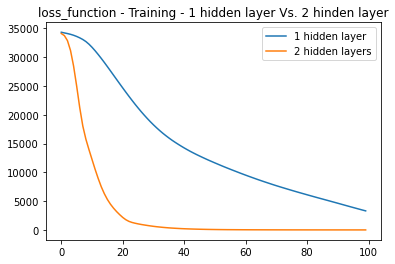

In [234]:
# Plot the loss function of the training results for the two models
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function - Training - 1 hidden layer Vs. 2 hinden layer")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()

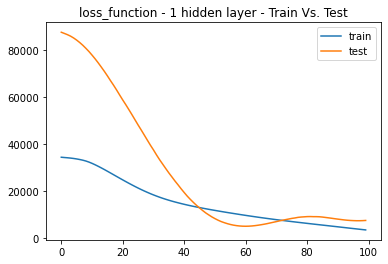

In [235]:
# Plot train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - 1 hidden layer - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

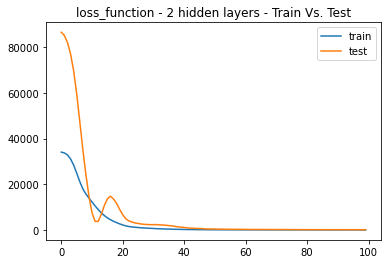

In [236]:
# Plot train vs test for deep net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - 2 hidden layers - Train Vs. Test")
plt.legend(["train", "test"])
plt.show()

In [237]:
# Show the model summaries
model_1.summary()

AttributeError: 'History' object has no attribute 'summary'

#### Split Data Between Training and Testing Sets

To avoid the dataset being randomized, manually create the training and testing sets using array slicing. Use 70% of the data for training and the remainder for testing.

In [238]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

#### Scale Data with `MinMaxScaler`

Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

**Note:** You need to scale both features and target sets.

In [240]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
y.reshape(1, -1)
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[118.11 118.38 118.68 ... 371.48 371.93 373.85].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. Both sets, training, and testing should be reshaped.

In [ ]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

---

### Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [ ]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Create the LSTM RNN Model Structure

Design the structure of your RNN LSTM as follows:

* Number of units per layer: `30` (same as the window size)

* Dropout fraction: `0.2` (20% of neurons will be randomly dropped on each epoch)

* Add three `LSTM` layers to your model, remember to add a `Dropout` layer after each `LSTM` layer, and to set `return_sequences=True` in the first two layers only.

* Add a `Dense` output layer with one unit.

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 8
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

#### Compile the LSTM RNN Model

Compile the model using the `adam` optimizer, and `mean_square_error` as loss function since the value you want to predict is continuous.

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Show the model summary
model.summary()

#### Train the Model

Train (fit) the model with the training data using `10` epochs and a `batch_size=90`. Since you are working with time-series data, remember to set `shuffle=False` since it's necessary to keep the sequential order of the data.

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

---

### Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of Real (`y_test`) vs. predicted values.

4. Plot the real vs. predicted values as a line chart.

#### Evaluate the Model

Use the `evaluate()` method of the model using the testing data.

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

#### Make Predictions

Use the `predict()` method of the model to make some closing gold price predictions using your brand new LSTM RNN model and your testing data. Save the predictions in a variable called `predicted`.

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
actual_vs_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = features_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
actual_vs_predicted.head()

In [ ]:
# Plot the real vs predicted prices as a line chart
actual_vs_predicted.plot(title="Actual Vs. Predicted Prices", figsize=(15, 10))